In [1]:
import numpy as np
import bz2
from collections import Counter
import re
import nltk
import torch
import math
import random
import keras
from torch import nn
from torch import optim
from torch import Tensor
from torch import LongTensor
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import logging
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
import seaborn as sns

In [2]:
logging.basicConfig(format='%(asctime)s - %(message)s', datefmt='%d-%b-%y %H:%M:%S')
logging.getLogger().setLevel(logging.INFO)
nn_Softargmax = nn.Softmax  # fix wrong name

In [3]:
train_dir = '/media/data/artifacts/2016/train/'
test_dir = '/media/data/artifacts/2016/vt_test/'
# test_dir = '/media/data/artifacts/vt/test/'
train_labels_dir = '/media/data/artifacts/2016/train_labels.txt'
test_labels_dir = '/media/data/artifacts/2016/vt_test_labels.txt'
# test_labels_dir = '/media/data/artifacts/vt/test_labels.txt'
word2vec_model_dir = '/media/data/artifacts/2016/final256.model'
# word2vec_model_dir = '/media/data/1000apks/first.model'
model_dir = '/media/data/artifacts/2016/models/'

In [4]:
!wc -l /media/data/artifacts/2016/train_labels.txt

154800 /media/data/artifacts/2016/train_labels.txt


In [5]:
!wc -l /media/data/artifacts/2016/vt_test_labels.txt
# !wc -l /media/data/artifacts/vt/test_labels.txt

2048 /media/data/artifacts/2016/vt_test_labels.txt


In [6]:
x = !ls -l /media/data/artifacts/2016/train | wc -l
len_train = int(x[0]) - 1
y = !ls -l /media/data/artifacts/2016/vt_test | wc -l
# y = !ls -l /media/data/artifacts/vt/test | wc -l
len_test = int(y[0]) - 1

In [7]:
print(len_train)
print(len_test)

154800
2048


### Load word2 vec model

In [8]:
word2vec_model = KeyedVectors.load(word2vec_model_dir, mmap='r')

09-Mar-21 17:28:15 - loading Word2VecKeyedVectors object from /media/data/artifacts/2016/final256.model
09-Mar-21 17:28:17 - loading vectors from /media/data/artifacts/2016/final256.model.vectors.npy with mmap=r
09-Mar-21 17:28:17 - setting ignored attribute vectors_norm to None
09-Mar-21 17:28:17 - loaded /media/data/artifacts/2016/final256.model


In [9]:
len(word2vec_model.wv.vocab)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


850193

### Create train and test labels

In [10]:
train_label_dict={}
count = 0
with open(train_labels_dir) as file:
    for _ in range(len_train):
        line  = file.readline().strip().split(",")
#         if line[0] in train_label_dict and line[1] == '0':
#             count+=1
#             print(line[0],line[1])
        train_label_dict[line[0]] = int(line[1])

In [11]:
test_label_dict={}
with open(test_labels_dir) as file:
    for _ in range(len_test):
        line  = file.readline().strip().split(",")
        test_label_dict[line[0]] = int(line[1])

### Create word2index and index2word dict

In [12]:
len(train_label_dict)

154800

In [13]:
len(test_label_dict)

2048

In [14]:
tokenizer = Tokenizer(filters='#\n')
tokenizer.fit_on_texts(word2vec_model.wv.vocab.keys())
word_index = tokenizer.word_index

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


In [15]:
idx2word = {v: k for k, v in word_index.items()}

In [16]:
len(word_index)

850192

In [17]:
type(word_index)

dict

In [18]:
android = 0
java = 0
amazon = 0
google = 0
apache = 0
facebook = 0
others = 0
o = []
apis = {"android":0,
        "java":0,
        "google":0,
#         "amazon":0,
        "facebook":0,
        "apache":0,
        "others":0}

for k,v in word_index.items():
    if k.find("android") != -1:
        apis['android'] += 1
        android += 1
    elif k.find("java") != -1:
        java += 1
        apis['java'] += 1
    elif k.find("google") != -1:
        google += 1
        apis['google'] += 1
#     elif k.find("amazon") != -1:
#         amazon += 1
#         apis['amazon'] += 1
    elif k.find("facebook") != -1:
        facebook += 1
        apis['facebook'] += 1
    elif k.find("apache") != -1:
        apache += 1
        apis['apache'] += 1
    else:
        o.append(k)
        others += 1
        apis['others'] += 1

In [19]:
apis

{'android': 336609,
 'java': 232249,
 'google': 8516,
 'facebook': 7664,
 'apache': 4431,
 'others': 260723}

In [20]:
print('android',android)
print('java',java)
print('google',google)
print('amazon',amazon)
print('facebook',facebook)
print('apache',apache)
print('others',others)

android 336609
java 232249
google 8516
amazon 0
facebook 7664
apache 4431
others 260723


In [21]:
cols = ["api-source","count"]
df_a = pd.DataFrame.from_dict(apis, orient='index').reset_index()

In [22]:
df_a.columns = cols
# df_a = df_a.sort_values(by='count', ascending=False)
df_a


,api-source,count
0,android,336609
1,java,232249
2,google,8516
3,facebook,7664
4,apache,4431
5,others,260723


In [23]:
pal = sns.color_palette("rocket", len(df_a))
# sns.set(rc={'figure.figsize':(8,5)})

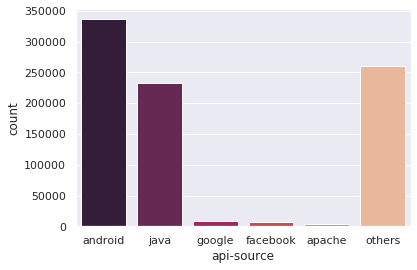

In [24]:
sns.set(style="darkgrid")
g = sns.barplot(x="api-source", y="count",data=df_a,palette=pal)
# g.set(yscale="log")

### Create Train and Test Generators

In [25]:
class TrainDataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, files_list, labels):
        'Initialization'
        self.labels = labels
        self.files_list = files_list

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.files_list)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.files_list[index]

        train_dir = '/media/data/artifacts/2016/train/'
        # Load data and get label
        #one_file = torch.load(train_dir + ID)
        one_file = open(train_dir + ID,'r').read().strip() 
        # one_file = torch.load(train_dir + ID + '.txt')

        X =  sequence.pad_sequences(tokenizer.texts_to_sequences([one_file]),maxlen=4000, padding='post',truncating='post')
    
        

        if self.labels[ID] == 1:
            y = [0,1]
        else:
            y = [1,0]

        #y = self.labels[ID]
        #y = torch.from_numpy(y)
        y = torch.FloatTensor(y)

        return X.squeeze(), y


In [26]:
class TestDataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, files_list, labels):
        'Initialization'
        self.labels = labels
        self.files_list = files_list

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.files_list)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.files_list[index]

        test_dir = '/media/data/artifacts/2016/vt_test/'
#         test_dir = '/media/data/artifacts/vt/test/'
        # Load data and get label

        one_file = open(test_dir + ID,'r').read().strip() 

        X =  sequence.pad_sequences(tokenizer.texts_to_sequences([one_file]),maxlen=4000, padding='post',truncating='post')
    
        

        if self.labels[ID] == 1:
            y = [0,1]           #malicious
        else:
            y = [1,0]           #benign

        #y = self.labels[ID]
        #y = torch.from_numpy(y)
        y = torch.FloatTensor(y)

        return X.squeeze(), y

In [27]:
train = list(train_label_dict.keys())
test = list(test_label_dict.keys())
partition = {}
partition['train'] = train
partition['test'] = test
train_labels= train_label_dict
test_labels= test_label_dict

In [28]:
params1 = {'batch_size': 20,
          'shuffle': True,
          'drop_last': True,
          'num_workers': 10}

params2 = {'batch_size': 16,
          'shuffle': False,
          'drop_last': True,
          'num_workers': 10}
max_epochs = 1

# Train Generators
train_set = TrainDataset(partition['train'], train_labels)
#training_generator = torch.utils.data.DataLoader(train_set, **params1)
training_set, val_set = torch.utils.data.random_split(train_set, [139800, 15000])
training_generator = torch.utils.data.DataLoader(training_set, **params1)
validation_generator = torch.utils.data.DataLoader(val_set, **params1)

# Test Generators
test_set = TestDataset(partition['test'], test_labels)
test_generator = torch.utils.data.DataLoader(test_set, **params2)



In [29]:
print(len(training_set))
print(len(val_set))
print(len(test_set))

139800
15000
2048


In [30]:
print(len(training_generator))
print(len(validation_generator))
print(len(test_generator))

6990
750
128


### Check GPU

In [31]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

device

device(type='cuda')

### Training

In [32]:
class Model(nn.Module):
    def __init__(self,embedding_matrix, vocab_size, output_size, embedding_dim, hidden_dim, n_layers=1, drop_prob=0.2):
        super(Model, self).__init__()
        self.hidden_layer = hidden_dim
        self.embedding_dim = embedding_dim
        self.embedding_matrix = embedding_matrix
        self.num_layers = n_layers
        self.bi_num_layers = 2
        self.output_size = output_size
        self.drop_prob = drop_prob

#         self.embedding = nn.Embedding(
#             num_embeddings=vocab_size,
#             embedding_dim=self.embedding_dim,
#         )
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix,freeze=True)
#         self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # pretrained_weight is a numpy matrix of shape (num_embeddings, embedding_dim)
#         self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.lstm = nn.LSTM(
            input_size=self.embedding_dim,
            hidden_size=self.hidden_layer,
            num_layers=self.num_layers,
            batch_first=True,
            bidirectional=True,
        )
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(p=self.drop_prob)
        self.alpha = nn.Linear(2*self.hidden_layer, 1)
        #self.r = nn.Linear(2*self.hidden_layer, 1)
        self.softmax = nn.Softmax(dim=1)
        self.fc = nn.Linear(2*self.hidden_layer, output_size)
        #self.sigmoid = nn.Sigmoid()
        self.softmax_fc = nn.Softmax(dim=1)

    def forward(self, x, prev_state):
        batch_size = x.size(0)
        embed = self.embedding(x)

        output, state = self.lstm(embed, prev_state)
        #print('lstm output',output.shape)
        # [10, 200, 256] 

        """
        ### Just LSTM
        o = self.tanh(output)
        o = self.fc(o)

        o = o[:, -1, :]
        o = self.softmax_fc(o)
        a_out = []
        return o, state, a_out
        ###
        """

        # attention layer
        output = self.tanh(output)
        output = self.dropout(output)
        a_out = self.alpha(output)
        a_out = self.softmax(a_out)
        #print('a_out',a_out.shape)
        #[10, 200 , 1]

        r_t =  torch.transpose(output, -1 , 1)
        #print('r_t',r_t.shape)
        # [10, 256, 200]
        
        r_out = torch.bmm(r_t, a_out)
        #print('r_out',r_out.shape)
        # [10, 256 , 1]

        out = r_out.squeeze()
        # [10, 256]

        out = self.tanh(out)
        out = self.dropout(out)
        out = self.fc(out)
        out = self.softmax_fc(out)
        #print('final_fc_out',out.shape)
        # [10,2]
        return out, state, a_out

    def init_state(self, batch_size):
        return (torch.zeros(self.bi_num_layers, batch_size, self.hidden_layer),
                torch.zeros(self.bi_num_layers, batch_size, self.hidden_layer))

In [33]:
batch_size = 16
criterion = nn.BCELoss()

In [34]:
# embedding_matrix = np.zeros((len(word2vec_model.wv.vocab)+1,50))
# for word, i in word_index.items():
#     embedding_matrix[i]=word2vec_model.wv[word]

In [35]:
embedding_matrix = torch.FloatTensor(word2vec_model.vectors)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  """Entry point for launching an IPython kernel.


In [36]:
vocab_size = len(word2vec_model.wv.vocab)+1
batch_size = 16
output_size = 2
embedding_dim = 256
#embedding_dim = 100
hidden_dim = 64
n_layers = 1
drop_prob=0.3
model = Model(embedding_matrix,vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob)
model = model.to(device)
model

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


Model(
  (embedding): Embedding(850193, 256)
  (lstm): LSTM(256, 64, batch_first=True, bidirectional=True)
  (tanh): Tanh()
  (dropout): Dropout(p=0.3, inplace=False)
  (alpha): Linear(in_features=128, out_features=1, bias=True)
  (softmax): Softmax(dim=1)
  (fc): Linear(in_features=128, out_features=2, bias=True)
  (softmax_fc): Softmax(dim=1)
)

In [210]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_params

435464067

In [211]:
columns = ['layers', 'shape', 'parameters']
df = pd.DataFrame(columns=columns)
n = []
s = []
p = []
r = []
for name, param in model.named_parameters():
    n.append(str(name))
    s.append(str(param.shape))
    p.append(str(param.numel()))
    r.append(str(param.requires_grad))

df['layers'] = n
df['shape'] = s
df['parameters'] = p
df['requires_grad'] = r
df

,layers,shape,parameters,requires_grad
0,embedding.weight,"torch.Size([850193, 512])",435298816,False
1,lstm.weight_ih_l0,"torch.Size([256, 256])",65536,True
2,lstm.weight_hh_l0,"torch.Size([256, 64])",16384,True
3,lstm.bias_ih_l0,torch.Size([256]),256,True
4,lstm.bias_hh_l0,torch.Size([256]),256,True
5,lstm.weight_ih_l0_reverse,"torch.Size([256, 256])",65536,True
6,lstm.weight_hh_l0_reverse,"torch.Size([256, 64])",16384,True
7,lstm.bias_ih_l0_reverse,torch.Size([256]),256,True
8,lstm.bias_hh_l0_reverse,torch.Size([256]),256,True
9,alpha.weight,"torch.Size([1, 128])",128,True


In [ ]:
model.train()
epochs = 20
counter = 0
clip = 5
print_every = 100
valid_loss_min = np.Inf
all_weights = []
all_train_loss = []
all_val_loss = []
eps = []
criterion = nn.BCELoss()
#criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.0005)
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=5e-4)
#optimizer = optim.Adam(model.parameters(), lr=0.01)
#optimizer = optim.RMSprop(model.parameters(), lr=0.01)
#val_dl = val_loader
model_dir = '/media/data/artifacts/2016/models/bi-lstm-2/'


for epoch in range(epochs):
    #state_h, state_c = model.init_state(sequence_length)
    model.train()
    h = model.init_state(batch_size)

    train_losses = []
    validation_losses = []

    for inputs, labels in training_generator:
        counter += 1
        h = tuple([e.data for e in h])
        h = [x.to(device) for x in h]
        inputs, labels = inputs.to(device).long(), labels.to(device)

        model.zero_grad()
        output, h, _ = model(inputs, h)
        loss = criterion(output.squeeze(), labels)
        train_losses.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        #nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        
    model.eval()
    val_h = model.init_state(batch_size)
    for inp, lab in validation_generator:
        val_h = tuple([each.data for each in val_h])
        val_h = [x.to(device) for x in val_h]
        inp, lab = inp.to(device).long(), lab.to(device)

        out, _ , _ = model(inp, val_h)
        val_loss = criterion(out.squeeze(), lab.float())
        validation_losses.append(val_loss.item())

        
    all_train_loss.append(np.mean(train_losses))
    all_val_loss.append(np.mean(validation_losses))
    eps.append(epoch+1)
    torch.save(model, model_dir + str(epoch+1) + "-final-bi-attn-512-1.pickle")
    df_loss = pd.DataFrame({'train_loss':all_train_loss})
    df_loss['validation_loss'] = all_val_loss
    df_loss['epochs'] = eps
    df_loss.to_csv(model_dir + 'bi_attn_loss_512.csv',mode='a', sep=',')
    
    logging.info("Epoch {}: {:.6f} loss, {:.6f} val loss".format(epoch+1, np.mean(train_losses), np.mean(validation_losses)))

06-Mar-21 15:43:18 - Epoch 1: 0.243494 loss, 0.214766 val loss
06-Mar-21 16:16:57 - Epoch 2: 0.199284 loss, 0.191397 val loss
06-Mar-21 16:50:36 - Epoch 3: 0.188968 loss, 0.189033 val loss
06-Mar-21 17:24:20 - Epoch 4: 0.184264 loss, 0.185065 val loss
06-Mar-21 17:57:58 - Epoch 5: 0.181625 loss, 0.187239 val loss
06-Mar-21 18:31:35 - Epoch 6: 0.178036 loss, 0.184098 val loss
06-Mar-21 19:05:11 - Epoch 7: 0.175919 loss, 0.182839 val loss
06-Mar-21 19:38:42 - Epoch 8: 0.174921 loss, 0.179733 val loss
06-Mar-21 20:12:20 - Epoch 9: 0.172870 loss, 0.183910 val loss
06-Mar-21 20:45:54 - Epoch 10: 0.171193 loss, 0.183574 val loss


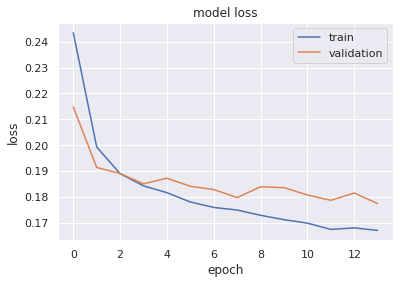

In [248]:
plt.plot(all_train_loss)
plt.plot(all_val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
# fig = plt.figure(figsize=(3,6))
plt.show()
# plt.savefig(model_dir + 'loss.png', bbox_inches='tight')

In [249]:
print(all_train_loss)

[0.24349445015570423, 0.19928375379620747, 0.18896797697761966, 0.18426437663934986, 0.1816249179480616, 0.17803563582197962, 0.17591905662655372, 0.1749205068585187, 0.1728700411871065, 0.17119323899223335, 0.16985218351245865, 0.1674177824560878, 0.16801988812022242, 0.1670318789191901]


In [109]:
# model_dir = '/media/data/artifacts/2016/models/bi-lstm-2/'
# df_loss = pd.DataFrame({'train_loss':all_train_loss})
# df_loss['validation_loss'] = all_val_loss
# df_loss.to_csv(model_dir + 'bi_attn_loss_128.csv', sep=',')

In [185]:
model_dir = '/media/data/artifacts/2016/models/bi-lstm-2/'
df = pd.read_csv(model_dir + 'bi_attn_loss_128_1.csv')
df.columns=['', 'train_loss', 'validation_loss','epoch']
df = df[['train_loss', 'validation_loss']]

In [186]:
df

,train_loss,validation_loss
0,0.256551,0.213617
1,0.205968,0.202231
2,0.194366,0.195901
3,0.187275,0.190395
4,0.183978,0.191282
5,0.180550,0.199938
6,0.178488,0.185364
7,0.176076,0.183030
8,0.174419,0.182051
9,0.172865,0.181735


[[<matplotlib.axis.XTick at 0x7fb539e42f50>,

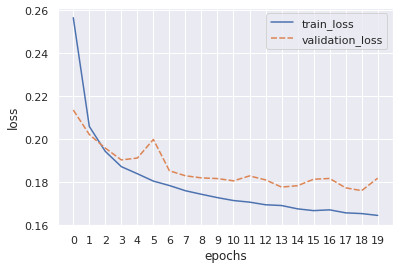

In [187]:
t = [x for x in range(0,20,1)]
sns.set(style="darkgrid")
g = sns.lineplot(data=df)
g.set(xlabel='epochs', ylabel='loss')
g.set(xticks=t)

### Save model

In [49]:
model_dir = '/media/data/artifacts/2016/models/bi-lstm-2/'
# torch.save(model, model_dir + "5-final-bi-attn-ep-10-6.pickle")
model = torch.load(model_dir + 'final-bi-attn-256-2.pickle')

In [50]:
# device = torch.device("cpu")

### Testing

In [51]:
test_losses = []
num_correct = 0
a_weights = []
pred_label = []
prediction = []
true_label = []
dict = {}
test_sen = []

h = model.init_state(batch_size)
model.eval()
with torch.no_grad():
    for inputs, labels in test_generator:
        h = tuple([each.data for each in h])
        h = [x.to(device) for x in h]
        inputs, labels = inputs.to(device).long(), labels.to(device)
        output, h, a_out = model(inputs, h)

        for out in output:
            o = out.cpu().numpy()
            prediction.append(o)
            """
            if o[0] == 0 :              #this mean [0,1] malicious
                pred_label.append(1)
            else:                       #this mean [1,0] benign
                pred_label.append(0)
            """


        for label in labels:
            l = label.cpu().numpy()
            if l[0] == 0 :              #this mean [0,1] malicious
                true_label.append(1)
            else:                       #this mean [1,0] benign
                true_label.append(0)

#         for inp in inputs:
#             test_sen.append(inp)
            
        for each_a_out in a_out:
            a_weights.append(each_a_out)
            
        test_loss = criterion(output.squeeze(), labels.float())
        test_losses.append(test_loss.item())

print("Test loss: {:.3f}".format(np.mean(test_losses)))
test_acc = num_correct/len(test_generator.dataset)
#print("Test accuracy: {:.3f}%".format(test_acc*100))

Test loss: 0.149


In [52]:
prediction1 = np.argmax(prediction, axis=1)  ## Prediction for bad reviews in terms of 0 and 1 for all test data
prediction_for_1=[] ## Prediction for bad reviews only
for each_prediction in prediction:
    prediction_for_1.append(each_prediction[1])

c = confusion_matrix(true_label,prediction1 )

In [53]:
c

array([[1501,   35],
       [  70,  442]])

In [54]:
test_label_dict

{'B410D5413B8A4E22EDBDFF0A940D8CB6B3ED53053AEA6CEEE6D840BCEA544867.txt': 0,
 '1B87D85D6043E41C7A9956CCFC98FAEA29B6D8DEE906FBDC6D2A402B02B6F4EA.txt': 0,
 'CD6565F52F6BD1049F16B5CC50DE0272DBA9B37ABC16D584CD6204F7592E9C61.txt': 0,
 'E6B121FE3BAA79171B35BF6BFF92DC0E9C91055A823FB5499B67BCA762541725.txt': 0,
 '13C371B87CFC2E77281597B3A6DD0A541C686281545D480F1582B3015FD3D046.txt': 0,
 'E80AB021C2AEA1C69AB19DC2045A1D6530BC385BF653800494D5975200F97BBC.txt': 0,
 'E9AB91DFBAEBD12DBF729430FBB5560E4EC46E13C5096CC3EB41BA994163880B.txt': 0,
 '1B98C42983F6193264D32CAAFE9BF15A8B17E8640E594087ED099BA4D9BDE493.txt': 0,
 'CBF33DF044B525C17EF505027A1B656AA5869E8C15E52FD77B66DD0F8C11E48C.txt': 0,
 'CDD61A9736E399699C595FE5657335748836FF6364042CCEB26D288697B71600.txt': 0,
 '2C053E78D068E6E4C85EA3B0A1567412727D9A6B43D4CDFDA12890B80AAE33DC.txt': 0,
 '3374FD8236FDF7A3A79ECF614C6C0D2DBC515C4B5AD6874482763F0E7A24012B.txt': 0,
 'D1CBD4BC273BDF8623AFDE6D5E71785D93A30062C6DE66918AAD5E329D22B268.txt': 0,
 '81C274E186

In [55]:
count = 0
for k,v in test_label_dict.items():
    if v == 1:
        count += 1
        
count 

512

[Text(0, 0.5, 'benign'), Text(0, 1.5, 'malicious')]

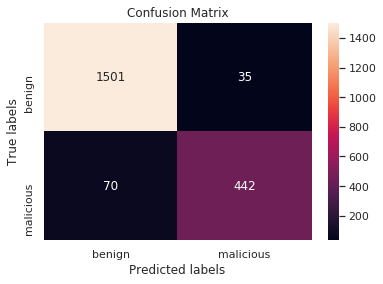

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(c, annot=True, fmt='g')

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['benign', 'malicious']) 
ax.yaxis.set_ticklabels(['benign', 'malicious'])

#### Evaluation Metrics

In [57]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import auc
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import f1_score
from inspect import signature

truelabel = true_label
predictedlabel = np.array(prediction1)

precision, recall, _ = precision_recall_curve(truelabel,np.array(prediction_for_1))
au = auc(recall, precision)
print("Area under graph "+str(au))
print("-------------------------------------------------")
rec_score = recall_score(truelabel,predictedlabel,pos_label=1,average='binary')
precise_score = precision_score(truelabel,predictedlabel,pos_label=1,average='binary')
f1 = f1_score(truelabel,predictedlabel,pos_label=1, average='binary')
print("Precision for Malicious apps "+str(precise_score))
print("Recall for Malicious apps "+str(rec_score))
print("F1-score for Malicious apps  " + str(f1))
print("-------------------------------------------------")
rec_score = recall_score(truelabel,predictedlabel,pos_label=0,average='binary')
precise_score = precision_score(truelabel,predictedlabel,pos_label=0,average='binary')
f1 = f1_score(truelabel,predictedlabel,pos_label=0, average='binary')
print("Precision for Benign apps "+str(precise_score))
print("Recall for Benign apps "+str(rec_score))
print("F1-score for Benign apps  " + str(f1))

Area under graph 0.9548100768448194
-------------------------------------------------
Precision for Malicious apps 0.9266247379454927
Recall for Malicious apps 0.86328125
F1-score for Malicious apps  0.8938321536905967
-------------------------------------------------
Precision for Benign apps 0.9554423933800127
Recall for Benign apps 0.9772135416666666
F1-score for Benign apps  0.9662053427743805


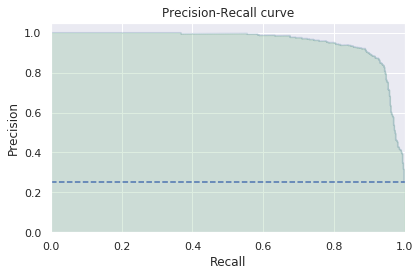

In [58]:
positive_cases = sum(truelabel)/len(truelabel)
plt.plot([0, 1], [positive_cases, positive_cases], linestyle='--')

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
                if 'step' in signature(plt.fill_between).parameters
                else {})
plt.step(recall, precision, color='b', alpha=0.2,
            where='post')
plt.fill_between(recall, precision, alpha=0.2, color='g', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve')
plt.tight_layout()